 Recurrent Neural Networks(Sentiment Analysis)<br>
Financial Phrases

# Neccessary Imports and Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing required libraries from different modules and giving them an alias
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [ ]:
# Reading text data from a text file with a different encoding and storing it in a variable
with open('/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.txt', 'r', encoding='ISO-8859-1') as file:
    df = file.readlines()

In [ ]:
import csv
# Defining the paths
input_path = '/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.txt' #declaring a variable to read the text file
output_path = '/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.csv' #declaring a variable to write the csv file

# Reading the content from the text file
with open(input_path, 'r',encoding='ISO-8859-1') as txt_file:
    lines = txt_file.readlines()


# Writing to the CSV file by iterating over each line in lines
with open(output_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows([line.strip()] for line in lines)

#printing message
print("Text file converted to CSV successfully.")


Text file converted to CSV successfully.


In [ ]:
# loading the dataset by using the above created csv file
data_path="/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.csv"
df = pd.read_csv(data_path,engine="python",encoding="ISO-8859-1")

# Data Cleaning and Visualization

In [ ]:
#printing the first 5 rows of dataset
df.head()

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"For the last quarter of 2010 , Componenta 's n..."
1,"In the third quarter of 2010 , net sales incre..."
2,Operating profit rose to EUR 13.1 mn from EUR ...
3,"Operating profit totalled EUR 21.1 mn , up fro..."
4,Finnish Talentum reports its operating profit ...


In [ ]:
#checking for any null values in the dataset
df.isnull().any()

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral    False
dtype: bool

In [ ]:
# Initializing lists to store data
sentiments = [] #initializing an empty array
texts = [] #initializing an empty array

# Iterate for each line and extract information
for line in lines:
    parts = line.strip().split('@') #spiliting the dataset from a keyword "@"
    if len(parts) == 2:
        text = parts[0].strip() #Fetching the text part
        sentiment = parts[1].strip() #Fetching the sentiment part
        sentiments.append(sentiment) #adding sentiment to the list
        texts.append(text) #adding text to the list

# Creating a DataFrame
df = { 'Label': sentiments, 'Text': texts}
data = pd.DataFrame(df)

# Saving the DataFrame to a CSV file
data.to_csv('/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.csv', index=False)

# Viewing the DataFrame
data

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,positive,"For the last quarter of 2010 , Componenta 's n..."
2,positive,"In the third quarter of 2010 , net sales incre..."
3,positive,Operating profit rose to EUR 13.1 mn from EUR ...
4,positive,"Operating profit totalled EUR 21.1 mn , up fro..."
...,...,...
2259,negative,Operating result for the 12-month period decre...
2260,negative,HELSINKI Thomson Financial - Shares in Cargote...
2261,negative,LONDON MarketWatch -- Share prices ended lower...
2262,negative,Operating profit fell to EUR 35.4 mn from EUR ...


<Axes: xlabel='count', ylabel='Label'>

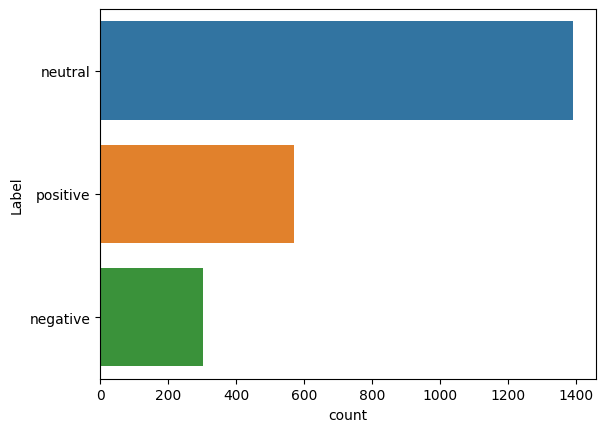

In [ ]:
#using seaborn to visualize labels in the dataset via count plot
sns.countplot(y="Label",data=data)

In [ ]:
#looking for null values
data.isnull().sum()

Label    0
Text     0
dtype: int64

In [ ]:
# removing unwanted text and characters
data['Text'] = data['Text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

In [ ]:
#viewing 5 random data from the dataset
data.sample(5)

,Label,Text
1523,neutral,The transaction is subject to a final agreemen...
2072,negative,17 March 2011 Goldman Sachs estimates that th...
1703,neutral,Profit after taxes totaled EUR 121 mn
1730,neutral,The business transfer will take effect from 1 ...
158,positive,Operating profit rose from EUR 194 mn to EUR 2...


In [ ]:
# normalizing text data by converting all of them into lowercase
data['Text'] = data['Text'].apply(lambda x: x.lower())

In [ ]:
def get_sequences(texts, max_seq_length=52):  # Change max_seq_length to match the model's expected input length
    # Initializing a Tokenizer to process the texts
    tokenizer = Tokenizer()
    # Fitting the tokenizer
    tokenizer.fit_on_texts(texts)
    # Converting the texts to sequences using the fitted tokenizer
    sequences = tokenizer.texts_to_sequences(texts)
    print("Vocab length:", len(tokenizer.word_index) + 1)
    # Pad sequences to the specified max_seq_length
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    return sequences

In [ ]:
sequences = get_sequences(texts) #fetching text using the afore created function

Vocab length: 6110


In [ ]:
def preprocess_inputs(df):
    # Making a duplicate of the Dataset to avoid modifying the original data
    df = df.copy()
    #fetching text using function
    sequences = get_sequences(df['Text'])
    #mapping the categorical data in sentiment column to numeric values
    label_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }
    #replacing the categorical data with mapped numeric values
    y = df['Label'].replace(label_mapping)
    #Spliting the dataset into train and test to validate
    train_sequences, test_sequences, y_train, y_test = train_test_split(
        sequences, y, train_size=0.7, shuffle=True, random_state=1)
    #returing variables
    return train_sequences, test_sequences, y_train, y_test, label_mapping

In [ ]:
# This line prepares the data for training and testing by converting text sequences,
# mapping labels and splitting the data into training and testing sets.
train_sequences, test_sequences, y_train, y_test, label_mapping = preprocess_inputs(data)

Vocab length: 6741


In [ ]:
# 'train_sequences' contains the preprocessed text sequences for the training set.
train_sequences

array([[   1,  176,   72, ...,    0,    0,    0],
       [   1,  157,   15, ...,    0,    0,    0],
       [2462,   28,  788, ...,    0,    0,    0],
       ...,
       [   1,   86, 1031, ...,    0,    0,    0],
       [ 827,   59,  944, ...,    0,    0,    0],
       [   1,  730,   68, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#y_train holds the corresponding labels or target values for the training set.
y_train

2252    0
259     2
1118    1
1910    0
2089    1
       ..
960     1
905     1
1096    1
235     2
1061    1
Name: Label, Length: 1584, dtype: int64

# Build a Model

In [ ]:
# inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
# x = tf.keras.layers.Embedding(
#     input_dim=10123,
#     output_dim=128,
#     input_length=train_sequences.shape[1]
# )(inputs)
# x = tf.keras.layers.GRU(256, return_sequences=True, activation='tanh')(x)
# x = tf.keras.layers.Flatten()(x)
# outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
# model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],)) # Input layer for sequences
x = tf.keras.layers.Embedding( # Embedding layer to convert tokenized sequences to dense vectors
    input_dim=10123, #Size of the vocab
    output_dim=128, # dimension of dense embedding
    input_length=train_sequences.shape[1]
)(inputs) #length of input sequence
# LSTM layer for sequence processing, returns sequences for each time step
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
# Flatten the sequence outputs for further processing
x = tf.keras.layers.Flatten()(x)
#Fully connected layer for classification, outputting class probabilities
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
# Create a Keras model with defined inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs)
# Print the summary of the model's architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 embedding (Embedding)       (None, 52, 128)           1295744   
                                                                 
 lstm (LSTM)                 (None, 52, 256)           394240    
                                                                 
 flatten (Flatten)           (None, 13312)             0         
                                                                 
 dense (Dense)               (None, 3)                 39939     
                                                                 
Total params: 1,729,923
Trainable params: 1,729,923
Non-trainable params: 0
_________________________________________________________________


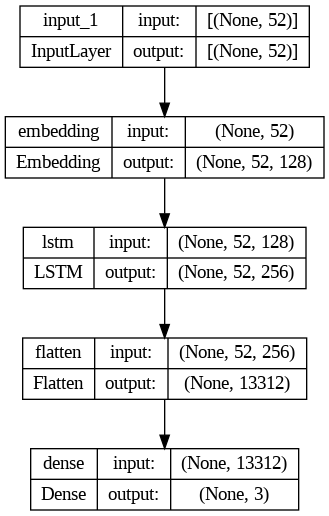

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', #defining loss function to be used
  optimizer='adam',  #defining optimizer to be used
  metrics=['accuracy']) # metric to track during training

# Training Model

In [ ]:
# Creating an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True )
# Train the model with the EarlyStopping callback
history = model.fit( train_sequences, y_train, #training data and labels to be used
                    validation_split=0.2, #reserves 20% of the training data for validation
                     batch_size=32, # specifies the number of samples per gradient update
                     epochs=10, #defines the number of training epochs to be run
                     callbacks=[early_stopping]) #adds the EarlyStopping callback function created

Epoch 1/10
40/40 [==============================] - 17s 246ms/step - loss: 0.8031 - accuracy: 0.6630 - val_loss: 0.6320 - val_accuracy: 0.7350
Epoch 2/10
40/40 [==============================] - 5s 121ms/step - loss: 0.4091 - accuracy: 0.8145 - val_loss: 0.6300 - val_accuracy: 0.7413
Epoch 3/10
40/40 [==============================] - 5s 121ms/step - loss: 0.1690 - accuracy: 0.9384 - val_loss: 0.7006 - val_accuracy: 0.8233
Epoch 4/10
40/40 [==============================] - 3s 72ms/step - loss: 0.0498 - accuracy: 0.9890 - val_loss: 0.4909 - val_accuracy: 0.8423
Epoch 5/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 1.1872 - val_accuracy: 0.8391
Epoch 6/10
40/40 [==============================] - 3s 66ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 1.0317 - val_accuracy: 0.8423


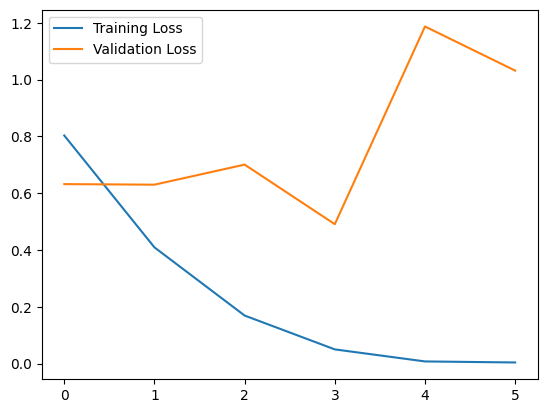

In [ ]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss') # using training loss
plt.plot(history.history['val_loss'], label='Validation Loss') #  using validation loss
plt.legend() #adding a legend
plt.show() #plotting

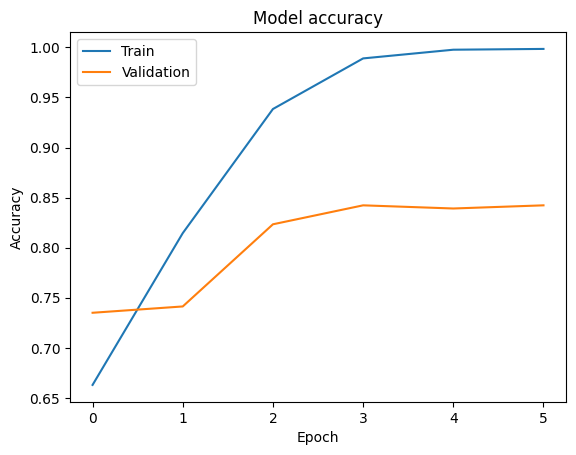

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy']) #using accuracy
plt.plot(history.history['val_accuracy']) #using val_accuracy
plt.title('Model accuracy') #title for the plot
plt.ylabel('Accuracy') #y-axis for the plot
plt.xlabel('Epoch') #x-axis for the plot
plt.legend(['Train', 'Validation'], loc='upper left')  #adding legend
plt.show() #plotting

# Evaluate the Model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_sequences, y_test)
#Printing the test loss and test accuracy, viewing 4 points after decimal
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

22/22 [==============================] - 0s 5ms/step - loss: 0.5395 - accuracy: 0.8353
Test Loss: 0.5395, Test Accuracy: 0.8353


In [ ]:
# Predicting class probabilities for the test sequences
y_pred = model.predict(test_sequences)
# Converting probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Convering numerical labels back to text labels
label_mapping_inv = {v: k for k, v in label_mapping.items()}
# Converting numerical test labels to text labels using the inverse label mapping
y_test_labels = y_test.replace(label_mapping_inv)
# Converting predicted class indices back to text labels using the label mapping
y_pred_labels = [label_mapping_inv[pred] for pred in y_pred_classes]
# Comparing actual labels with predicted labels
for true_label, pred_label in zip(y_test_labels, y_pred_labels):
    print(f"True Label: {true_label}\tPredicted Label: {pred_label}")


22/22 [==============================] - 0s 4ms/step
True Label: negative	Predicted Label: negative
True Label: neutral	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Label: negative
True Label: neutral	Predicted Label: neutral
True Label: positive	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Label: negative
True Label: neutral	Predicted Label: neutral
True Label: positive	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Lab

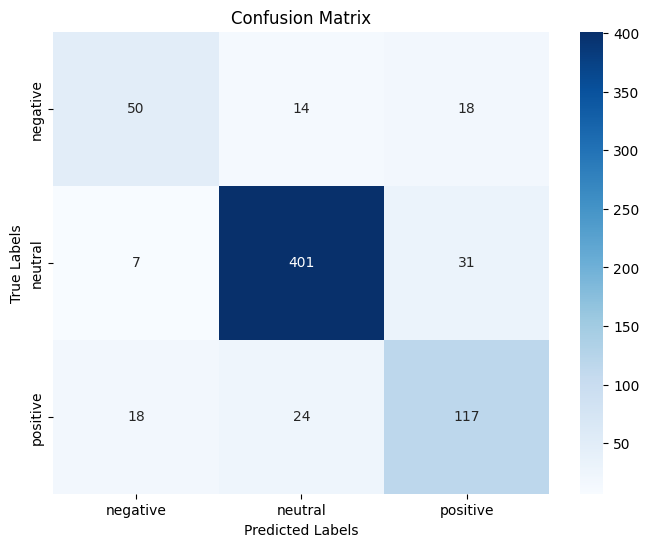

In [ ]:
# Creating a list of label strings in the correct order
label_strings = ['negative', 'neutral', 'positive']

# Converting true and predicted labels to their corresponding integer values
y_test_int = y_test.replace(label_mapping)
y_pred_int = [label_mapping[pred] for pred in y_pred_labels]

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_int, labels=list(label_mapping.values()))

# Creating a DataFrame for the confusion matrix
conf_df = pd.DataFrame(conf_matrix, index=label_mapping.keys(), columns=label_mapping.keys())

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6)) #defining size of the plot
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues") #using seaborn to plot the heatmap
plt.xlabel('Predicted Labels') #x-axis for the plot
plt.ylabel('True Labels')  #y-axis for the plot
plt.title('Confusion Matrix') #title for the plot
plt.show() #plotting

In [ ]:
# Specifying row index to check
row_to_check = 2248

# Checking if the row index is valid
if 0 <= row_to_check < len(data):
    # Extracting the text from the selected row and put it into a list
    text_data = [data.iloc[row_to_check]["Text"]]  # Get the text from the selected row

    # Preprocessing the text using your get_sequences function
    sequences = get_sequences(text_data)

    # Make predictions using the trained model on the preprocessed sequence
    user_pred = model.predict(sequences)

    # printing the values
    print(text_data)

    # Geting the predicted class index and map it to the corresponding label
    user_pred_class = np.argmax(user_pred, axis=1)[0]
    user_pred_label = label_mapping_inv[user_pred_class]
    #printing the predicted label
    print("Predicted Sentiment:", user_pred_label)
else:
    #printing the error message
    print("Invalid row number. Please provide a valid row number.")


Vocab length: 15
1/1 [==============================] - 0s 61ms/step
[' capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy ']
Predicted Sentiment: neutral


In [ ]:
# (positive)
# operating profit totalled eur 211 mn  up from eur 186 mn in 2007  representing 97  of net sales
# clothing retail chain seppl s sales increased by 8  to eur 1552 mn  and operating profit rose to eur 311 mn from eur 171 mn in 2004
# operating profit was eur 245 mn  up from eur 230 mn
# (neutral)
# according to gran  the company has no plans to move all production to russia  although that is where the company is growing
# capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy
# (negative)
# ['finnish silicon wafer technology company okmetic oyj  omx helsinki  okm1v  reported on thursday  7 august  an operating profit of eur5 3 m for the period januaryjune 2008  up from eur3 3 m in the corresponding period in 2007 ']
# ['finnish broadband data communication systems provider teleste oyj hel  tlt1v said yesterday it returned to a net profit of eur 27 million usd 38 m for the first nine months of 2010 versus a net loss of eur 579000 for the same period of 2009 ']



In [ ]:
#prompting user to enter a text to predict, the program will terminate if user enters quit
#iterating the code with while loop and providing conditions
while True:
    user_input = input("Enter a text (or 'exit' to quit): ")

    if user_input.lower() == 'exit':
        break

    # Preprocess the user's input text
    user_sequence = get_sequences([user_input])

    # Make predictions using the model
    user_pred = model.predict(user_sequence)

    # Assuming label_mapping_inv is a dictionary that maps class indices to labels
    user_pred_class = np.argmax(user_pred, axis=1)[0]
    user_pred_label = label_mapping_inv[user_pred_class]
    #printing predicted labels
    print("Predicted Sentiment:", user_pred_label)

Enter a text (or 'exit' to quit): capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy
Vocab length: 15
1/1 [==============================] - 0s 18ms/step
Predicted Sentiment: neutral
Enter a text (or 'exit' to quit): operating profit totalled eur 211 mn  up from eur 186 mn in 2007  representing 97  of net sales
Vocab length: 17
1/1 [==============================] - 0s 31ms/step
Predicted Sentiment: positive
Enter a text (or 'exit' to quit): finnish silicon wafer technology company okmetic oyj  omx helsinki  okm1v  reported on thursday  7 august  an operating profit of eur5 3 m for the period januaryjune 2008  up from eur3 3 m in the corresponding period in 2007
Vocab length: 34
1/1 [==============================] - 0s 19ms/step
Predicted Sentiment: negative
Enter a text (or 'exit' to quit): finnish broadband data communication systems provider teleste oyj hel  tlt1v said yesterday it returned to a net profit of eur 27 million usd 3